## 1D Finite Difference Wave propagation in a homogeneous medium
The notebook has several steps:
* Simulation of the wave
* Reading on a receiver a certain distance
* Comparing our results with analytical solution

## Simulation of the wave

In [1]:
# Import Libraries
# ----------------------------------------------
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt


# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

Initialise all the parameters required in the code. We will not initialise dt, and obtain it from CPL condition. That way, we won't have to worry about the stability of our solution.

In [2]:
# Parameter Configuration 
# -----------------------

nx   = 5500        # number of grid points in x-direction
xmax = 5500        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
x    = dx* np.arange(nx); # spatial fabric


# Medium velocity
c0   = 334.         # wave speed in medium (m/s)
c    = np.zeros(nx)
c    = c + c0       # Homogeneous medium


# CPL Stability Criterion
eps= 0.8; # <1
dt= eps/c0*dx; # Now we don't have to worry about the stability of the solution
nt   = 1005          # maximum number of time steps
time = np.linspace(0 * dt, nt * dt, nt); # time fabric

print('dt= ', dt);
print('Duration of simulation would be ', time[-1], ' sec');

dt=  0.002395645152684266
Duration of simulation would be  2.407623378447687  sec


Our system is set and initialised. We will proceed to having a source function that will cause the change in our homogeneous medium. We will first choose the first derivative of the Gaussian function, the output then being the Gaussian function, which when narrowed gives a Dirac-delta function.
The output response of the Dirac-delta function is the Green's function which when estimated gives easy solution to any source function.

I don't understand it very well now (Aug 6) but maybe you do.

In [3]:
# Source time function

def source_fn(f0, t0, fn):
    src  = np.zeros(nt + 1); 
    if fn== 'Gaussian':
        src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2));
    elif fn== 'sin':
        src  = np.zeros(nt); 
        src[0:round(c0/f0)]= np.cos(2*3.14*f0*(time[0:round(c0/f0)]-t0));
    elif fn== 'delta':
        src  = np.zeros(nt); 
        src[round(t0/dt)]= 1;
    return src;

(1005,) (1005,)


<IPython.core.display.Javascript object>


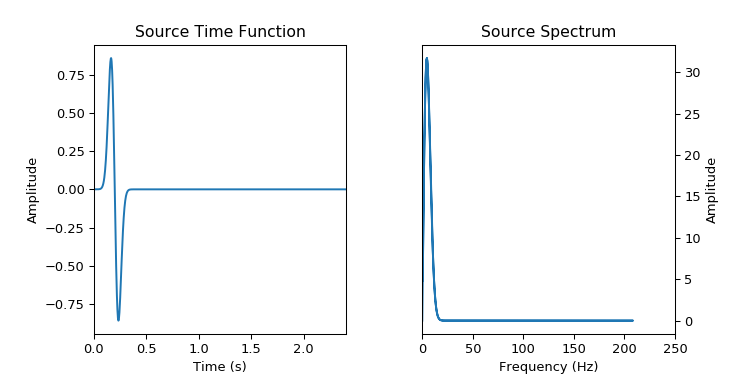

In [5]:
# Plot source time function

# Source function parameters
isrc = int(nx/2)    # source location in grid in x-direction
f0   = 5 # dominant frequency of the source (Hz)
t0   = 1. / f0 # source time shift (This is equal to one period)
src= source_fn(f0, t0, 'Gaussian');
print(src.shape, time.shape)
# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(8, 4))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt ) # time domain to frequency domain (corrected May 3, 2020)
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")


<IPython.core.display.Javascript object>


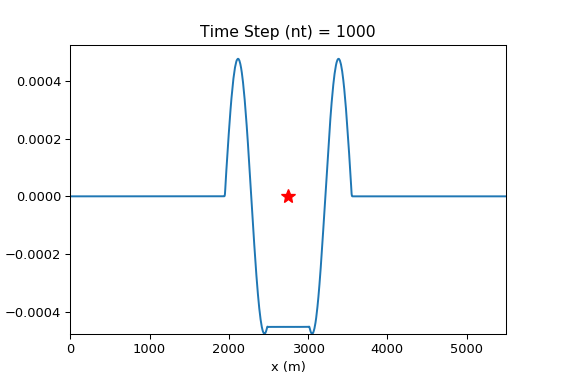

In [117]:
# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold= np.zeros_like(p);
pnew= np.zeros_like(p);

plt.ion()
fig2  = plt.figure(figsize=(6, 4))
gs2   = gridspec.GridSpec(1,1,width_ratios=[1],hspace=0.3, wspace=0.3)

# Plot the medium of propagation 
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, xmax)
ax3.set_ylim(-0.0001, 0.0001)
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('Pressure Amplitude')

# FD wave propagation
d2px = np.zeros(nx) # 2nd space derivative of p
for it in range(nt):
    for i in range(1, nx - 1):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2;

    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px;
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2;
    pold, p = p, pnew;
    
    # Snapshot
    idisp = 5 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        ax3.set_ylim(np.min(p), 1.1*np.max(p))
        up31.set_ydata(p)
        plt.gcf().canvas.draw()

So what happens when you pluck a string, it starts oscillating at certain harmonics, right? We should not confuse it with propagating a wavefield. Let's see this in a little detail. At time t= 0, we have, at a particular point, a certain displacement. When we release it, the displacement does not propagate as it is throughout the space. Therefore, if the source fn is a delta function, we won't observe a delta propagating along the space. It is the case when source function f is known, but the solution u is not.

When one talks about propagating a particular wavefield throughout the space, what one provides is actually the displacement at a point for a certain time duration. Let's try to propagate a simple sin fn throughout the space.

## Reading on a receiver a certain distance

Now, let's put a receiver some distance apart, and observe what is recorded on it.

<IPython.core.display.Javascript object>


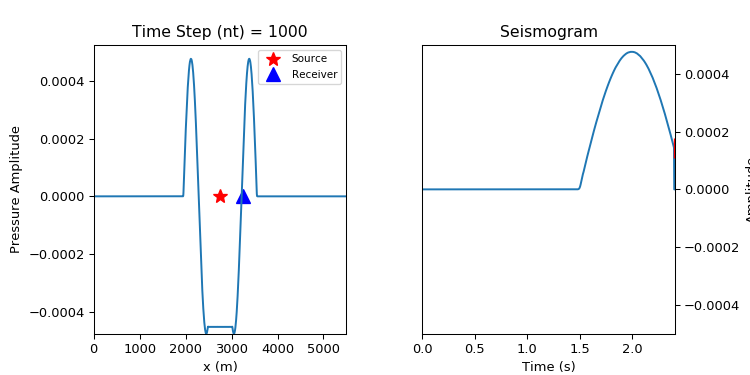

In [137]:
ir= isrc+ 500; # Receiver location
receiver= np.zeros(nt);

# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold= np.zeros_like(p);
pnew= np.zeros_like(p);

plt.ion()
fig2  = plt.figure(figsize=(8, 4))
gs2   = gridspec.GridSpec(1,2,hspace=0.3, wspace=0.3)

# Plot the medium of propagation 
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source
leg2,= ax3.plot(ir, 0, 'b^', markersize=11) # plot position of the receiver
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, xmax)
ax3.set_ylim(-0.0001, 0.0001)
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('Pressure Amplitude')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=8, numpoints=1)

ax4  = plt.subplot(gs2[1])
up41,= ax4.plot(time, receiver) # update recorded seismogram each time step
up42,= ax4.plot([0], [0], 'r|', markersize=15) # update time step position
leg4,= ax4.plot(0,0,'b-',markersize=1) # plot numerical solution
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_xlim(time[0], time[-1])

lim= 0.0005
ax4.set_ylim(-lim, lim)
ax4.set_title('Seismogram')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Amplitude')

# FD wave propagation
d2px = np.zeros(nx) # 2nd space derivative of p
for it in range(nt):
    for i in range(1, nx - 1):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2;

    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px;
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2;
    pold, p = p, pnew;
    
    receiver[it]= p[ir];
    
    # Snapshot
    idisp = 5 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        ax3.set_ylim(np.min(p), 1.1*np.max(p))
        up31.set_ydata(p)
        up41.set_data(time, receiver)
        up42.set_data(time[it], receiver[it])
        plt.gcf().canvas.draw()

## Comparing our results with analytical solution

The Green's function for our system is a Heaviside function. Therefore, for any other source function, we may obtain the analytical solution by convolution of the Green's function with the source function.

Note that for different systems, Green's function is different. You can find some reference on this wiki page: https://en.wikipedia.org/wiki/Green%27s_function

<IPython.core.display.Javascript object>


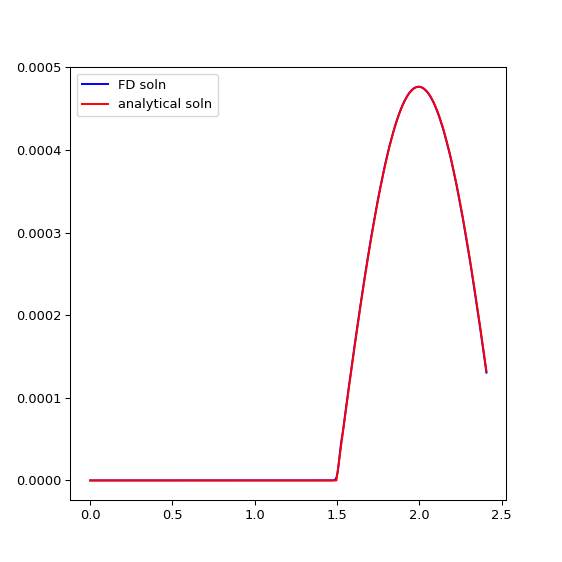

In [135]:
G    = np.zeros_like(time)
for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - np.abs(x[ir] - x[isrc]) / c0) >= 0:
        G[it] = 1. / (2 * c0)
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from the maximum amplitude

fig,ax =plt.subplots(figsize= (6,6))
ax.plot(time, receiver, 'b-', label= 'FD soln')
ax.plot(time, Gc, 'r', label= 'analytical soln')
ax.legend()

That's it! We've done it.